# Prediction of Regional Rail Performance

![Time Arrival](waterloocancelledtrains.jpg)

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, time

# 1. Preview of data

`Note`: The Regional Rail system consists of commuter rail service on 13 branches to more than 150 active stations. It uses On-Time Performance (OTP) to measure service reliability. OTP identifies the number of trains for all rail lines that arrive at their scheduled destination at the scheduled time. 

In [62]:
otp = pd.read_csv('../TrwTr.Rail_Performance_Prediction/otp.csv')
train = pd.read_csv('../TrwTr.Rail_Performance_Prediction/trainView.csv', low_memory=False)

In [63]:
print(otp.info())
display(otp.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882015 entries, 0 to 1882014
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   train_id      object
 1   direction     object
 2   origin        object
 3   next_station  object
 4   date          object
 5   status        object
 6   timeStamp     object
dtypes: object(7)
memory usage: 100.5+ MB
None


,train_id,direction,origin,next_station,date,status,timeStamp
0,778,N,Trenton,Stenton,2016-03-23,1 min,2016-03-23 00:01:47
1,598,N,Thorndale,Narberth,2016-03-23,1 min,2016-03-23 00:01:58
2,279,S,Elm,Ridley Park,2016-03-23,2 min,2016-03-23 00:02:02
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,On Time,2016-03-23 00:03:19
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,On Time,2016-03-23 00:03:35


In [64]:
# Parse datetime columns
otp['timeStamp'] = pd.to_datetime(otp['timeStamp'], errors='coerce')
otp['date'] = pd.to_datetime(otp['date'], errors='coerce').dt.date

# Extract features
otp['day'] = otp['timeStamp'].dt.day_name()
otp['hour'] = otp['timeStamp'].dt.hour

In [65]:
# Clean up train IDs
otp['train_id'] = otp['train_id'].str.replace(r'[A-Za-z./\s-]+', '', regex=True)

In [66]:
# Standardize delay column
otp['status'] = (
    otp['status']
    .astype(str)
    .str.replace('On Time', '0', regex=False)
    .str.replace(' min', '', regex=False)
)
otp['delay'] = pd.to_numeric(otp['status'], errors='coerce')

In [67]:
df = otp.drop(['status'], axis=1)
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882015 entries, 0 to 1882014
Data columns (total 9 columns):
 #   Column        Dtype         
---  ------        -----         
 0   train_id      object        
 1   direction     object        
 2   origin        object        
 3   next_station  object        
 4   date          object        
 5   timeStamp     datetime64[ns]
 6   day           object        
 7   hour          int32         
 8   delay         int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(6)
memory usage: 122.0+ MB
None


,train_id,direction,origin,next_station,date,timeStamp,day,hour,delay
0,778,N,Trenton,Stenton,2016-03-23,2016-03-23 00:01:47,Wednesday,0,1
1,598,N,Thorndale,Narberth,2016-03-23,2016-03-23 00:01:58,Wednesday,0,1
2,279,S,Elm,Ridley Park,2016-03-23,2016-03-23 00:02:02,Wednesday,0,2
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,2016-03-23 00:03:19,Wednesday,0,0
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,2016-03-23 00:03:35,Wednesday,0,0


# 2. Exploratory Data Analysis

In [68]:
print('📅 Date range:', df['date'].min(), '→', df['date'].max())
print('🚉 Unique next stations:', df['next_station'].nunique())
print('Range of delays:', df['delay'].min(), '→', df['delay'].max())
print('Filtered range (delay != 999):',
     df.loc[df['delay'] != 999, 'delay'].min(),
     '→',
     df.loc[df['delay'] != 999, 'delay'].max()) #999 is a suspended train

📅 Date range: 2016-03-23 → 2016-11-06
🚉 Unique next stations: 154
Range of delays: 0 → 1440
Filtered range (delay != 999): 0 → 1440


## Delay by direction

In [69]:
# Mean delay by direction
direction_summary = (
    df.query('delay != 999')
    .groupby('direction', as_index=False)
    .agg(avg_delay=('delay', 'mean'))
) 
print(direction_summary)

  direction  avg_delay
0         N   3.624162
1         S   4.741128


In [70]:
# Two-sample t-test
south = df.loc[df['direction'] == 'S', 'delay'].dropna()
north = df.loc[df['direction'] == 'N', 'delay'].dropna()

from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(south, north, equal_var=True)
print(f'T-test: t={t_stat:.3f}, p-value={p_val:.3e}')

T-test: t=49.564, p-value=0.000e+00


## Delay by day of week

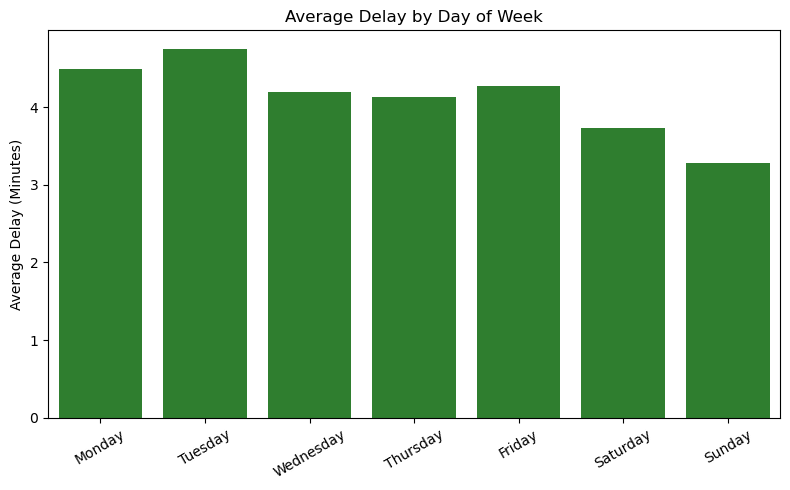

In [71]:
# Average delay by day of week
avg_day = (
    df.query('delay != 999')
    .groupby('day', as_index=False)
    .agg(avg_delay=('delay', 'mean'))
)
#order days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_day['day'] = pd.Categorical(avg_day['day'], categories=day_order, ordered=True)
avg_day = avg_day.sort_values('day')

plt.figure(figsize=(8,5))
sns.barplot(data=avg_day, x='day', y='avg_delay', color='forestgreen')
plt.title('Average Delay by Day of Week')
plt.xlabel('')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Delay by hour

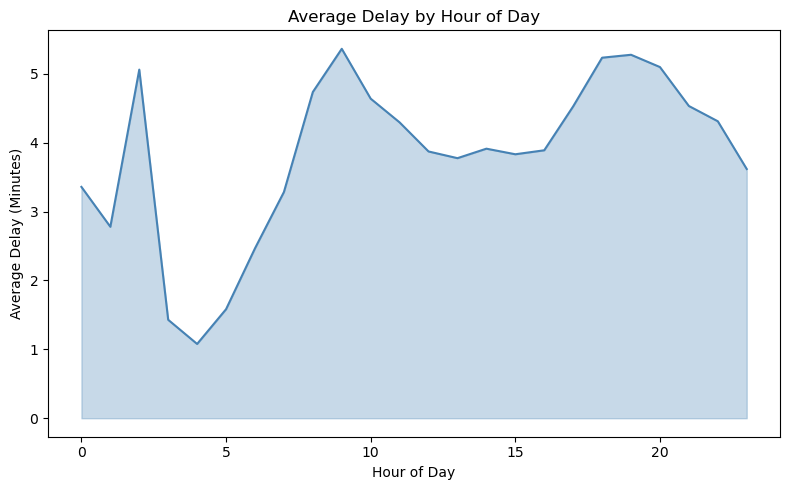

In [72]:
# Average delay by hour
avg_hour = (
    df.query('delay != 999')
    .groupby('hour', as_index=False)
    .agg(avg_delay=('delay','mean'))
)

plt.figure(figsize=(8, 5))
sns.lineplot(data=avg_hour, x='hour', y='avg_delay', color='steelblue')
plt.fill_between(avg_hour['hour'], avg_hour['avg_delay'], color='steelblue', alpha=0.3)
plt.title('Average Delay by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delay (Minutes)')
plt.tight_layout()
plt.show()

## Delay by terminal/origin

In [73]:
# Average delay by terminal/origin
df['origin'].unique()

array(['Trenton', 'Thorndale', 'Elm', 'Airport Terminal E-F', 'Trent',
       'Powelton Yard', 'Marcus Hook', 'Wilmington', 'Warminster',
       'Doylestown', 'Chestnut Hill East', 'Elwyn', nan, 'Fern Rock TC',
       'Suburban Station', 'Frazer Yard', 'Glenside', 'Roberts Yard',
       'West Trenton Yard', 'County', 'Overbrook Int', 'South Fox Chase',
       'Chestnut Hill West', 'Thorn', 'Newark', 'Cynwyd', 'Elwyn Station',
       'Bryn Mawr', 'Lansdale', 'Media', 'Warm', '30th Street Station',
       'Paoli', 'Highland', 'Secane', 'Miquon', 'Elm St', 'Carmel South',
       'Carmel', 'Jenkin', 'Link Belt', 'Temple U', 'Colmar', 'Wayne',
       'West', 'University City', 'Spring', 'Ford', 'Jenkintown-Wyncote',
       'West Trenton', 'Airport Jct', 'Dale', 'Fox Chase', 'Frazer Int',
       'Norristown TC', 'Jefferson Station', 'Long', 'Vine',
       'Airport Terminal C-D', 'Norwood', 'Doyle', 'Bala',
       'Bryn Mawr Int', 'Whitford', 'North Broad St', '30th South',
       'Hunt', 'Pr

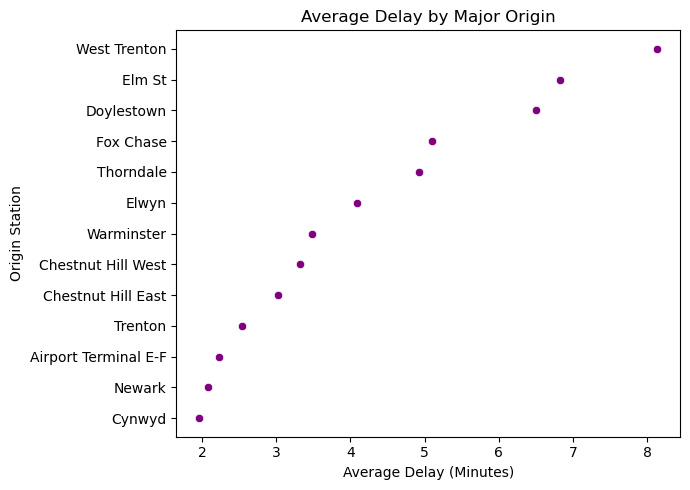

In [74]:
terminals = [
    'Doylestown', 'Warminster', 'West Trenton', 'Trenton', 'Fox Chase',
    'Chestnut Hill East', 'Chestnut Hill West', 'Elm St', 'Thorndale',
    'Elwyn', 'Newark', 'Airport Terminal E-F', 'Cynwyd'
]

# Origin
avg_origin = (
    df.query('delay != 999 and origin in @terminals')
    .groupby('origin', as_index=False)
    .agg(avg_delay=('delay', 'mean'))
    .sort_values('avg_delay', ascending=False)
)

plt.figure(figsize=(7,5))
sns.scatterplot(data=avg_origin, y='origin', x='avg_delay', color='purple')
plt.title('Average Delay by Major Origin')
plt.xlabel('Average Delay (Minutes)')
plt.ylabel('Origin Station')
plt.tight_layout()
plt.show()

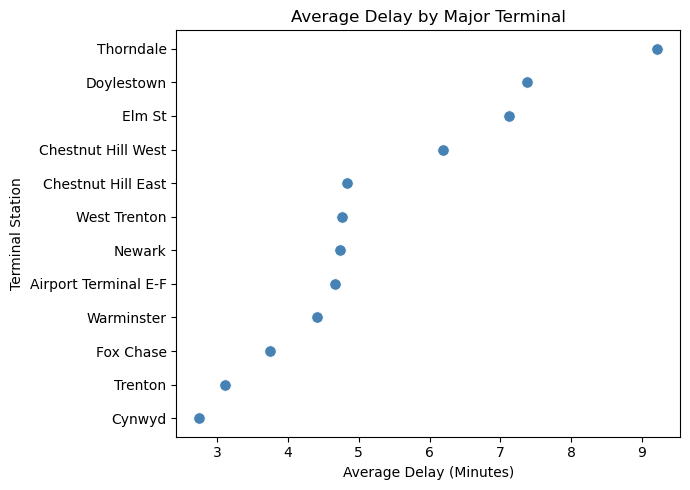

In [75]:
# Terminal
avg_terminal = (
    df.query('delay != 999 and next_station in @terminals')
    .groupby('next_station', as_index=False)
    .agg(avg_delay=('delay', 'mean'))
    .sort_values('avg_delay', ascending=False)
)

plt.figure(figsize=(7, 5))
sns.scatterplot(data=avg_terminal, x='avg_delay', y='next_station', color='steelblue', s=70)
plt.title('Average Delay by Major Terminal')
plt.xlabel('Average Delay (Minutes)')
plt.ylabel('Terminal Station')
plt.tight_layout()
plt.show()

## Delay at Elkins Park station

In [76]:
# Converts any mix of datetime.date, strings, or objects into true Timestamps.
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Define the data range
start_date = pd.Timestamp('2016-06-01')
end_date = pd.Timestamp('2016-06-08')

# Filters
mask = (
    (df['next_station'] == 'Elkins Park') &
    (df['date'].between(start_date, end_date))
)

ep = df[mask]
ep.head()

,train_id,direction,origin,next_station,date,timeStamp,day,hour,delay
648108,474,N,Airport Terminal E-F,Elkins Park,2016-06-01,2016-06-01 00:00:34,Wednesday,0,0
648203,476,N,Airport Terminal E-F,Elkins Park,2016-06-01,2016-06-01 00:30:34,Wednesday,0,1
648334,403,S,Glenside,Elkins Park,2016-06-01,2016-06-01 04:29:20,Wednesday,4,3
648369,405,S,Glenside,Elkins Park,2016-06-01,2016-06-01 04:58:21,Wednesday,4,2
648435,6400,N,Powelton Yard,Elkins Park,2016-06-01,2016-06-01 05:25:02,Wednesday,5,0


In [77]:
ep_late = ep.query('delay >= 6')

print("Delay summary for late trains:")
display(ep_late['delay'].describe())

Delay summary for late trains:


count    102.000000
mean       8.019608
std        2.856226
min        6.000000
25%        6.000000
50%        7.000000
75%        9.000000
max       22.000000
Name: delay, dtype: float64

## Travel time between two stations

In [83]:
STATION_A, STATION_B = 'Elkins Park', 'Suburban Station'
DATE_BEGIN, DATE_END = '2016-06-01', '2016-06-08'

# Train IDs passing through both station
trains_ab = df.query("next_station == @STATION_A or next_station == @STATION_B")
train_ids = trains_ab.groupby('train_id')['next_station'].nunique()
train_ids = train_ids[train_ids == 2].index #trains that visit both

# Extract time for Station A & B
pointA = df.loc[
    df['train_id'].isin(train_ids) & (df['next_station'] == STATION_A),
    ['train_id', 'timeStamp']
].rename(columns={'timeStamp':'timeStamp_A'})
pointB = df.loc[
    df['train_id'].isin(train_ids) & (df['next_station'] == STATION_B),
    ['train_id', 'timeStamp']
].rename(columns={'timeStamp':'timeStamp_B'})

# Merge on train_id and calculate time differences
line = pd.merge(pointA, pointB, on=['train_id'])

# Filter by desired date range (based on time at A)
line = line.query("@DATE_BEGIN <= timeStamp_A <=@DATE_END")

print(line.columns.tolist())


['train_id', 'timeStamp_A', 'timeStamp_B']


In [85]:
def travel_time(row):
    """Return absolute time difference in seconds, ignoring >7h."""
    delta = abs(row['timeStamp_B'] - row['timeStamp_A'])
    return delta.total_seconds() if delta.total_seconds() < 7 * 3600 else np.nan

line['seconds'] = line.apply(travel_time, axis=1)
line = line.dropna(subset=['seconds'])
line['minutes'] = line['seconds'] / 60

# View summary
print(line[['train_id', 'timeStamp_A', 'timeStamp_B', 'minutes']].head())

       train_id         timeStamp_A         timeStamp_B    minutes
778985      474 2016-06-01 00:00:34 2016-05-31 23:35:11  25.383333
779134      476 2016-06-01 00:30:34 2016-06-01 00:03:19  27.250000
779393      403 2016-06-01 04:29:20 2016-06-01 04:54:17  24.950000
779610      405 2016-06-01 04:58:21 2016-06-01 05:22:17  23.933333
779806     6400 2016-06-01 05:25:02 2016-06-01 04:58:40  26.366667



Travel time summary between Elkins Park and Suburban Station:


count    606.000000
mean      25.008196
std        2.567307
min       19.383333
25%       23.400000
50%       24.933333
75%       26.233333
max       43.283333
Name: minutes, dtype: float64

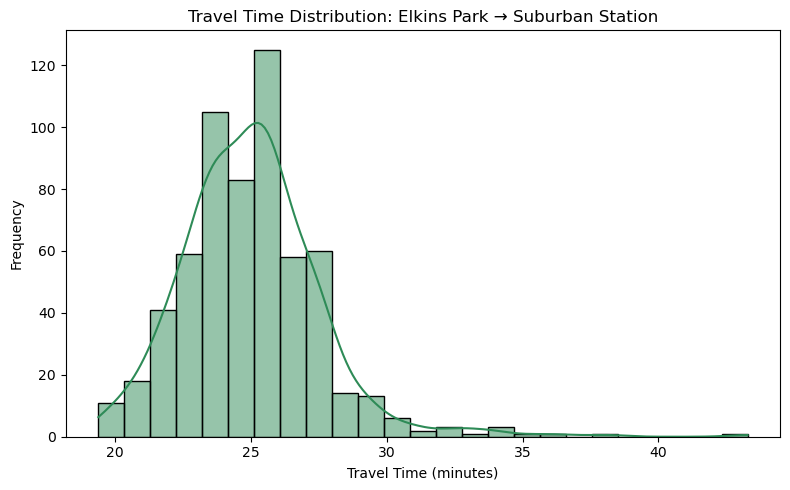

In [86]:
# Travel time summary 
print(f'\nTravel time summary between {STATION_A} and {STATION_B}:')
display(line['minutes'].describe())

# Distribution plot
plt.figure(figsize=(8,5))
sns.histplot(line['minutes'], bins=25, kde=True, color='seagreen')
plt.title(f'Travel Time Distribution: {STATION_A} → {STATION_B}')
plt.xlabel('Travel Time (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()